# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Import modules and configure the notebook.

In [1]:
import os

# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_drone

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_drone)

<module 'ae353_drone' from 'C:\\Users\\phlee\\OneDrive\\Documents\\Aero stuff\\AE353\\programming\\ae353-fa23\\ae353-installation-tests\\tests\\ae353_drone.py'>

Create simulator.

In [2]:
simulator = ae353_drone.Simulator(display=True)

## Example of how to add a drone and run a simulation

Define a controller for the drone.

In [3]:
class RobotController:
    def __init__(self, limiter=None):
        self.dt = 0.01
        self.limiter = limiter

    def get_color(self):
        return [0., 1., 0.]

    def reset(self, pos):
        self.xhat = np.zeros(12)
        self.user_data = {
            'tau_x_des': 0.,
            'tau_y_des': 0.,
            'tau_z_des': 0.,
            'f_z_des': 0.,
        }

    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        tau_x = 0.
        tau_y = 0.
        tau_z = 0.
        f_z = 0.
        
        self.user_data['tau_x_des'] = tau_x
        self.user_data['tau_y_des'] = tau_y
        self.user_data['tau_z_des'] = tau_z
        self.user_data['f_z_des'] = f_z

        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)

        return tau_x, tau_y, tau_z, f_z

Add the drone to the simulator. There are three arguments:

* `RobotController` is the class definition
* `'my_netid'` is the name of the drone
* `'my_image.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [4]:
simulator.add_drone(RobotController, 'my_netid', 'my_image.png')

Reset the drone (i.e., place it at a random location in the start ring).

In [5]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [6]:
simulator.run(max_time=5.0)

## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get drone by name.

In [7]:
drone_name = 'my_netid'
drone = simulator.get_drone_by_name(drone_name)

if drone is None:
    drone_names = '\n'.join([d['name'] for d in simulator.drones])
    msg = f'The simulator has no drone with name "{drone_name}".'
    if len(drone_names) == 0:
        msg += f' The simulator has no drones at all, in fact.'
    else:
        msg += f' The simulator has these drones:'
        msg += f'\n==========\n{drone_names}\n==========\n'
    print(msg)

Extract data.

In [8]:
data = drone['data'].copy()

Convert all lists in data to numpy arrays.

In [9]:
for key in data.keys():
    if key != 'user_data':
        data[key] = np.array(data[key]).T
for key in data['user_data'].keys():
    data['user_data'][key] = np.array(data['user_data'][key]).T

Did the drone finish? If so, what was the time at which it finished? If not, was it still running (or was there likely an error)?

In [10]:
if drone['finish_time'] is None:
    if drone['running']:
        print(f'The drone "{drone["name"]}" did not finish.')
    else:
        print(f'The drone "{drone["name"]}" did not finish and was no longer running.')
else:
    print(f'The drone "{drone["name"]}" finished with time: {drone["finish_time"]}')

The drone "my_netid" did not finish.


Plot results.

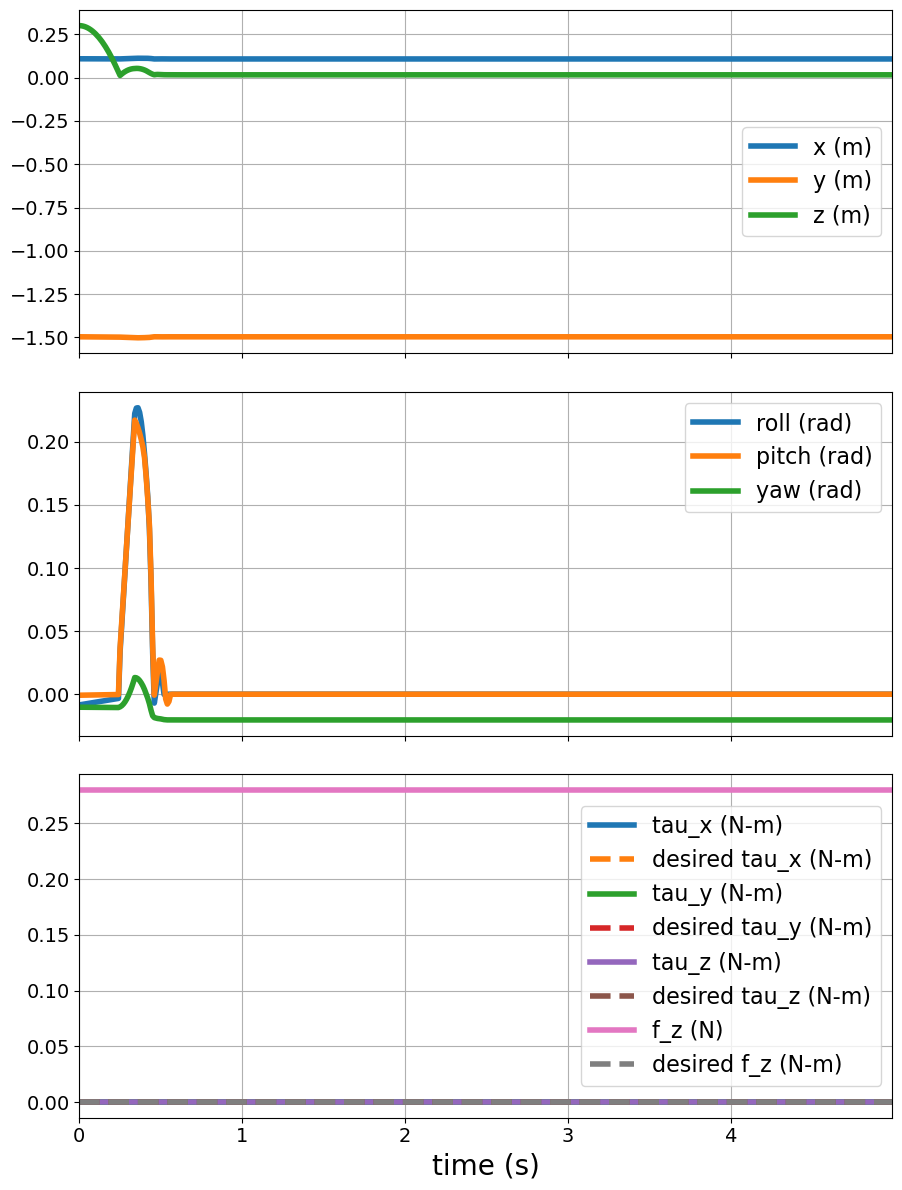

In [11]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_rpy, ax_act) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['tau_x_des'], '--', label='desired tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['tau_y_des'], '--', label='desired tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['tau_z_des'], '--', label='desired tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'], label='f_z (N)', linewidth=4)
ax_act.plot(data['t'], data['user_data']['f_z_des'], '--', label='desired f_z (N-m)', linewidth=4)
ax_act.grid()
ax_act.legend(fontsize=16)
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [12]:
simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [13]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [14]:
simulator.run(max_time=5.0)

## Example of how to show results, change views, keep running

Show results (so far).

In [15]:
simulator.show_results()

FINISHED

STILL RUNNING
 my_netid            
 template            

FAILED


View from behind a particular drone.

In [16]:
simulator.camera_droneview('template')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [17]:
simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [18]:
simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [19]:
simulator.run(max_time=5.0)

Show results (so far).

In [20]:
simulator.show_results()

FINISHED

STILL RUNNING
 my_netid            
 template            

FAILED


## Example of how to clear and reload drones

Clear all drones.

In [21]:
simulator.clear_drones()

Load drones again from `students` directory.

In [22]:
simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [23]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [24]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [25]:
simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [26]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [27]:
simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [28]:
simulator.camera_droneview('template')

Display a snapshot.

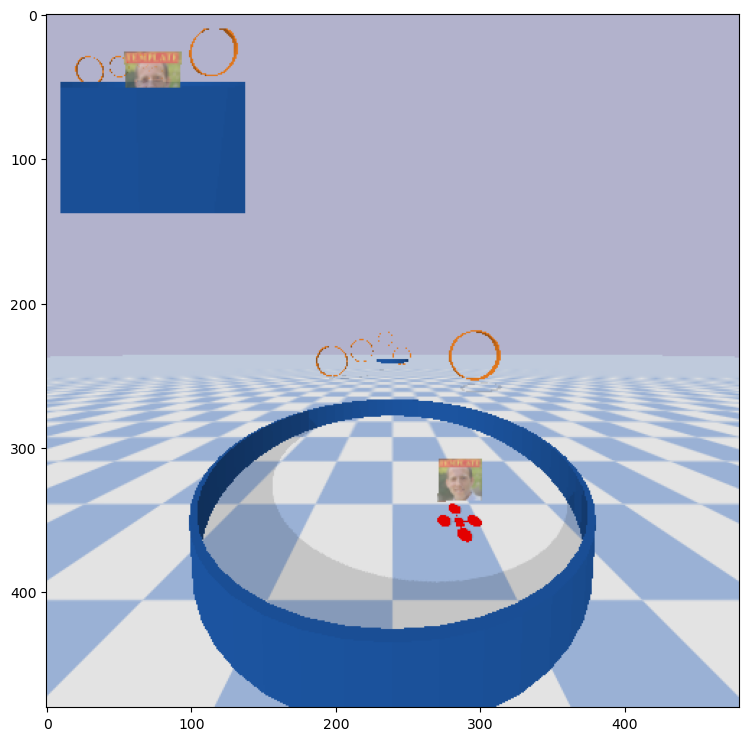

In [29]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)